In [3]:
import json
import re
import glob
import os
import pandas as pd
import numpy as np
import librosa
import sys
from pydub import AudioSegment
from scipy.io import wavfile
# import noisereduce as nr
import matplotlib.pyplot as plt
import matplotlib.transforms as mpt
from pathlib import Path

# 获取当前工作目录的绝对路径
current_directory = Path.cwd()
# 获取根目录（上两级）
root_directory = current_directory.parents[0]
# 将根目录添加到系统路径中
sys.path.append(str(root_directory))
ROOT = Path(os.path.relpath(root_directory, Path.cwd()))  # relative

def noiseReduce(
    y: np.ndarray = None,
    sr: int = None,
    prop_decrease: float = 0.8,
    stationary: bool = False,
) -> np.ndarray:
    """将重采样后的数据y_resampled进行降噪，消除非人声噪音.

     noiseReduce库参数：https://github.com/timsainb/noisereduce

     参数 ：
         y:
             加载的音频文件的时域信号，是一个一维的NumPy数组。
         sr:
             音频的采样率。
         thresh_n_mult_nonstationary:
             降噪的幅度，只能用于动态降噪中，数值越大，降噪的幅度越大。
         prop_decrease:
            降噪的比例，数字1表示降噪百分百。
         stationary:
             布尔值，True表示平稳降噪 ，False表示非平稳降噪。

    返回：
        降噪后的一维的NumPy数组的音频文件的时域信号。
    """
    reduced_noise = nr.reduce_noise(
        y=y,
        sr=sr,
        prop_decrease=prop_decrease,
        stationary=stationary,
    )
    vt_audio = np.asarray(reduced_noise)
    vt_sr = sr

    return vt_audio, vt_sr

In [4]:
def xfrVocalTract(
    audio_dir: Path = None,
    dataset_name: str = None,
    audio_name: str = None,
    target_sr: int = 16000,
) -> tuple:
    """按照target_sr进行重采样后，将声道数转化为指定数（一般项目需求为单声道）

    假设某一首歌的路径为 /Users/lijianxin/speech_recognition/audio/mp3/xxx.mp3

    参数：
        audio_dir：
            默认根目录为setting文件中的UPLOAD_FILE_DIR，eg：audio文件的路径。
        dataset_name：
            音频文件除去根目录和音频名之间的部分，eg：mp3。
        audio_name:
            音频名,eg:xxx.mp3。
        target_sr：
            目标的采样率，16000为常用的采用率。
        vt_num:
            需要设置的声道数。

    返回：
        1个元组，单声道音频文件的时域信号（一维的NumPy数组）y_resampled 和目标采样率target_sr。
    """

    if dataset_name is None:
        raise ValueError("音频文件夹不能为空")

    if audio_name is None:
        raise ValueError("文件夹下的音频文件名不能为空")

    audio_path = os.path.join(audio_dir, dataset_name, audio_name)  # 使用 / 拼接路径

    # 读取音频文件
    y, sr = librosa.load(audio_path, sr=None)

    # 重采样
    y_resampled = librosa.resample(y, orig_sr=sr, target_sr=target_sr)

    # 将音频信号转换为单声道
    y_resampled = librosa.to_mono(y_resampled)

    return y_resampled, target_sr

In [5]:
def getWordInfoList(transfer_json: list) -> dict:
    """由API转写结果json数据生成一个eigen_list字典

    参数：
        transfer_json(list):
            downloadOrderResult函数的返回结果。
    返回：
        一个包含eigen_list的字典
    """
    # 初始化一个空列表，用于存储预处理的数据格式
    output_list = []

    # 遍历原始数据中的每个字典
    for item in transfer_json:
        # 提取 "json_1best" 键对应的值（一个JSON字符串）
        json_string = item["json_1best"]
        # 将JSON字符串解析为字典，并添加到输出列表中
        output_list.append(eval(json_string))

    # 初始化一个空列表，用于存储最终的数据格式
    eigen_list = []

    # 遍历原始数据中的每个字典
    for item in output_list:
        sentence_bg = float(item["st"]["bg"])
        ws_list = item["st"]["rt"][0]["ws"]
        for word in ws_list:
            wb_value = word["wb"] * 10
            we_value = word["we"] * 10
            start_time = (sentence_bg + wb_value) / 1000
            end_time = (sentence_bg + we_value) / 1000
            for cw in word["cw"]:
                if re.search(r'[\u4e00-\u9fff]', cw["w"]):  # 判断是否包含中文字符
                    eigen_list.append({
                        "word": cw["w"],
                        "eigen": {
                            "start_time": start_time,
                            "end_time": end_time,
                        }
                    })
    # 返回名为 eigen_list 的字典
    return {"eigen_list": eigen_list}

In [6]:
def audioWordSeg(
        eigen_list: dict = None,
        reduced_noise: np.ndarray = None,
        sr: int = None,
        delay_second: float = 0.13,
        word_time_delay_ahead=0.12,
        word_time_delay_behind=0.1
) -> dict:
    """按照getWordInfoList的结果列表，以词为单位，将音频时域信息序列进行切割，eg："来"的时间间隔为1.3秒，要获取这个时间间隔内的音频信息。

    参数：
        eigen_list(dict)：
            传入需要提取的JSON文件，字典文件中包括start_time,end_time,word。
        reduced_noise:
            降噪后音频的时域信息。
        sr：
            采样率。
        delay_second:
            延后的原因是科大讯飞识别的延后秒数近似常量，默认为0.15。
        word_time_delay_ahead:
            计算首个字的音长所延后的秒数，多次测试后默认为0.12
        word_time_delay_behind:
            计算最后的字的音长所延后的秒数，多次测试后默认为0.1

    返回：
        eigen_list：
            在传入的JSON文件中，增加了以词为单位的时间间隔和该时间段内的时域信息。eg：
    {'eigen_list': [{'word': '起来',
       'eigen': {'start_time': 13.0,
        'end_time': 14.39,
        'audio_segment': array([ 8.5642641e-05, -5.3360149e-05, -2.1816693e-05, ...,
                2.0035163e-02,  2.3617115e-02,  1.1252311e-02], dtype=float32),
        'times': 1.3900000000000006,
        'word_start_time' :...,
        'word_end_time' :...,}} ,..., {'word'....}]}

    """

    eigen_list = eigen_list["eigen_list"]

    eigen_segments = []  # 用来存储子字典eigen_segment
    """遍历JSON文件中的子字典eigen_list，获取其中的每个词的起始和结束时间，并按时间段进行切割音频，返回出np.ndarray类型"""
    for item in eigen_list:
        # times = item["eigen"]["end_time"] - item["eigen"]["start_time"]
        # times = round(times, 3)
        if len(item["word"]) > 1:
            start_time = round(item["eigen"]["start_time"] + delay_second, 3)
            end_time = round(item["eigen"]["end_time"] + delay_second * 0.4, 3)
            word_start_time = round(item["eigen"]["start_time"] + word_time_delay_ahead, 3)
            word_end_time = round(item["eigen"]["end_time"] + word_time_delay_behind, 3)
        elif len(item["word"]) == 1:
            start_time = round(item["eigen"]["start_time"] + delay_second * 0.7, 3)
            end_time = round(item["eigen"]["end_time"] + delay_second * 0.6, 3)
            word_start_time = start_time
            word_end_time = end_time
        word = item["word"]
        times = word_end_time - word_start_time
        times = round(times, 3)
        start_time += (end_time - start_time) * 0.1
        end_time -= (end_time - start_time) * 0.1

        # 将时间转换为样本索引
        start_sample = int(start_time * sr)
        end_sample = int(end_time * sr)

        # 根据样本索引切割时域信号
        audio_segment = reduced_noise[start_sample:end_sample]

        # 构建新的子字典
        eigen_segment = {
            "word": word,
            "eigen": {
                "start_time": start_time,
                "end_time": end_time,
                "seg_seq": audio_segment,
                "times": times,
                "word_start_time": word_start_time,
                "word_end_time": word_end_time
            },
        }

        eigen_segments.append(eigen_segment)
    eigen_list = {"eigen_list": eigen_segments}

    return eigen_list

In [7]:
def calAudioFreq(reduced_noise: np.ndarray, sr: int, fmax: float = 2093.0, fmin: float = 65.0) -> list:
    """使用Pyin算法来估计各时刻的基音频率，生成一个元组，包括基频列表和基频对应的times列表.

    reduced_noise:
        noiseReduce的返回结果。
    sr：
        noiseReduce的返回的采样率。
    fmax：
        估计的最大频率，默认为2093.0。
    fmin:
        估计的最小频率，默认为65.0。

    返回：
        Freq_list：
            基频列表。
        times_list：
            各基频对应的times的列表。
    """
    # Freq_list 以赫兹为单位的基频时间序列。voiced_flag 包含指示帧是否有声的布尔标志的时间序列；voiced_probs 包含帧有声概率的时间序列。
    Freq_list, voiced_flag, voiced_probs = librosa.pyin(
        y=reduced_noise, sr=sr, fmin=fmin, fmax=fmax
    )

    times_list = librosa.times_like(Freq_list)
    Freq_list = Freq_list.tolist()
    times_list = times_list.tolist()
    return Freq_list, times_list

In [8]:
def getWordFreqSeq(word_dict: dict, Freq_list: list, times_list: list) -> dict:
    """传入eigen_list的一个字典元素，根据start_time和end_time将该字典元素对应的歌词的基频序列保存到字典中

    参数：
        word_dict:
            audioWordSeg返回结果中的eigen_list的一个元素，eg：{"word": "起来","eigen": {"seg_seq": null,"times": 2,"start_time": 1.85,"end_time": 3.85 }}。
        Freq_list：
            基频列表，calAudioFreq的返回结果。
        times_list：
            各基频对应的times的列表，calAudioFreq的返回结果。


    返回：
        rs_dict:
            返回一个新的字典，形如：{"word":xx, "eigen":{"seg_seq":xx,"times":xx,"start_time":xx,"end_time":xx,"Freq_seq":xx}}
    """

    # 获取子字典中"eigen"的value值
    item = word_dict["eigen"]
    start_time = item["start_time"]
    end_time = item["end_time"]

    # 通过科大讯飞返回的新的开始和结束的时间，获取在librosa返回的时间列表的索引
    indices = [index for index, time in enumerate(times_list) if start_time <= time <= end_time]
    Freq_seq = [Freq_list[index] for index in indices]
    time_seq = [times_list[index] for index in indices]

    item["Freq_seq"] = Freq_seq
    item["time_seq"] = time_seq
    rs_dict = word_dict

    return rs_dict

In [9]:
def getFreqOnset(word_dict: dict, sr: int) -> dict:
    """给定getWordFreqSeq的返回结果使用CQT色度图并给定word长度进行聚类，得到每个word的切割点时间序列

    当word长度>1时，如果：
        没有获得除0以外的切割点，返回时间序列为[0]，代表这个word长度大于1但识别不到切割点（普遍因为word同调）
        获得除0以外的切割点，返回时间序列为[a,b]，将0去掉，a,b为非0的切割点时间
    当word长度=1时，
        返回时间序列为空，代表这个word长度=1，不需要切割点
    将得到的切割时间点序列作为seg_time_list键值添加到输入的字典中。

    参数：
        word_dict(dict):
            getWordFreqSeq的返回结果
        sr(int):
            seg_seq信号序列的采样率

    返回：
        一个字典，结构如下：
            word：词
            eigen：字典，结构如下
                seg_seq：该词对应的ndaaray类型信号序列
                times：歌词持续时间
                start_time
                end_time
                word_start_time
                end_start_time
                Freq_seq：该word的基频f0序列
                time_list：该word的基频f0序列的时间序列
                seg_time_list：本函数获得的长度为word字数的切割时间列表，如果word长度为1，则列表为空。

    """
    eigen = word_dict["eigen"]
    word_len = len(word_dict["word"])
    chroma = librosa.feature.chroma_cqt(y=eigen["seg_seq"], sr=sr)
    bounds = librosa.segment.agglomerative(chroma, word_len)
    bound_times = librosa.frames_to_time(bounds, sr=sr)
    if word_len > 1:
        if len(bound_times) > 1:
            bound_times = np.delete(bound_times, 0).tolist()
        else:
            bound_times = [0]
    elif word_len == 1:
        bound_times = []
    word_dict["eigen"]["seg_time_list"] = bound_times

    return word_dict

In [7]:
folder_path = ROOT / "resultJson" / "国歌"
json_files = glob.glob(os.path.join(folder_path, "*.json"))
# json_files

In [ ]:
for jfile in json_files:
    file_name = os.path.basename(jfile).replace("_orderResult.json", ".mp3_seg.wav")
    # vt_audio, sr = xfrVocalTract(audio_dir=ROOT / "audio", dataset_name="国歌", audio_name=file_name)
    vt_audio, sr = librosa.load(ROOT / "audio" / "国歌" / file_name)
    Freq_list, times_list = calAudioFreq(reduced_noise=vt_audio, sr=sr)
    
    with open(jfile, "r", encoding="gbk") as f:
        data = json.load(f)
    word_dict = getWordInfoList(data)
    wordseg_dict = audioWordSeg(eigen_list=word_dict, reduced_noise=vt_audio, sr=sr)

    for i in range(len(wordseg_dict["eigen_list"])):
        item = wordseg_dict["eigen_list"][i]
        fs_dict = getWordFreqSeq(word_dict=item, Freq_list=Freq_list, times_list=times_list)
        eigen_dict = fs_dict["eigen"]
        chroma = librosa.feature.chroma_cqt(y=eigen_dict["seg_seq"], sr=sr)
        bounds = librosa.segment.agglomerative(chroma, len(fs_dict["word"]))
        bound_times = librosa.frames_to_time(bounds, sr=sr)
        
        
    print(wordseg_dict)

# 从此处开始为歌词维度的基频测试

In [27]:
with open(r"D:\my_knowledge\research_assistant\python_project\speech_recognition\resultJson\国歌全\44022404090109-32bbcd278e593d9bdc4b4d42e5880579_orderResult.json", "r", encoding="gbk") as f:
    data = json.load(f)

In [28]:
eigen_list = getWordInfoList(data)
# eigen_list

In [29]:
vt_audio, sr = xfrVocalTract(audio_dir=ROOT / "audio", dataset_name="qilai", audio_name="song_demo.mp3")
y, sr = librosa.load(r"D:\my_knowledge\research_assistant\python_project\speech_recognition\audio\国歌\44022404090109-32bbcd278e593d9bdc4b4d42e5880579.mp3_seg.wav")
# y, sr = noiseReduce(y=y, sr=sr)

In [30]:
wordseg_dict = audioWordSeg(eigen_list=eigen_list, reduced_noise=y, sr=sr)
# wordseg_dict

In [31]:
Freq_list, times_list = calAudioFreq(reduced_noise=y, sr=sr)

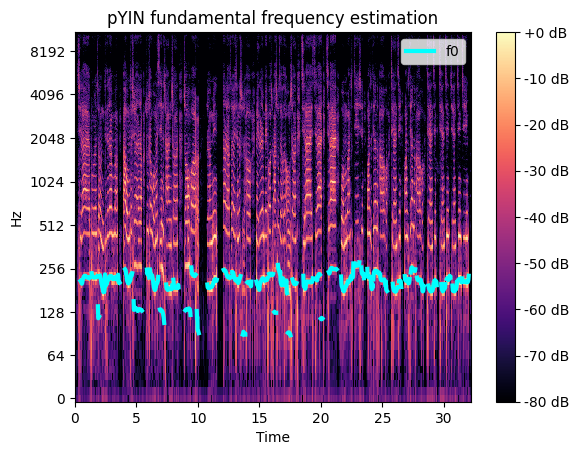

In [32]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='pYIN fundamental frequency estimation')
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(times_list, Freq_list, label='f0', color='cyan', linewidth=3)
ax.legend(loc='upper right')

D:\miniconda3\envs\speech_recognition_new\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=532
  warnings.warn(
D:\miniconda3\envs\speech_recognition_new\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=266
  warnings.warn(
D:\miniconda3\envs\speech_recognition_new\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=532
  warnings.warn(
D:\miniconda3\envs\speech_recognition_new\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=266
  warnings.warn(
D:\miniconda3\envs\speech_recognition_new\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=645
  warnings.warn(
D:\miniconda3\envs\speech_recognition_new\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too larg

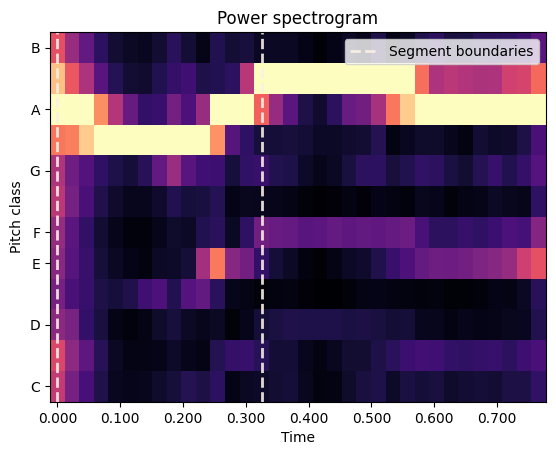

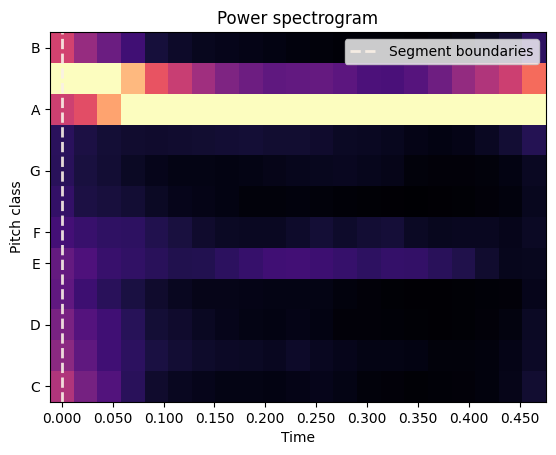

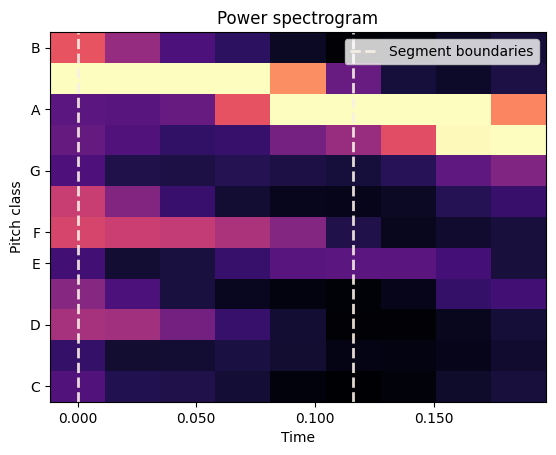

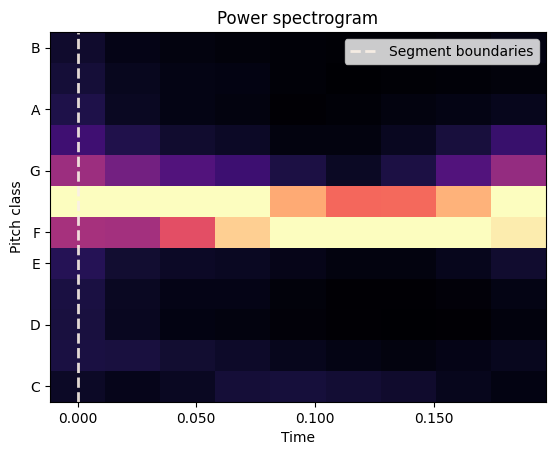

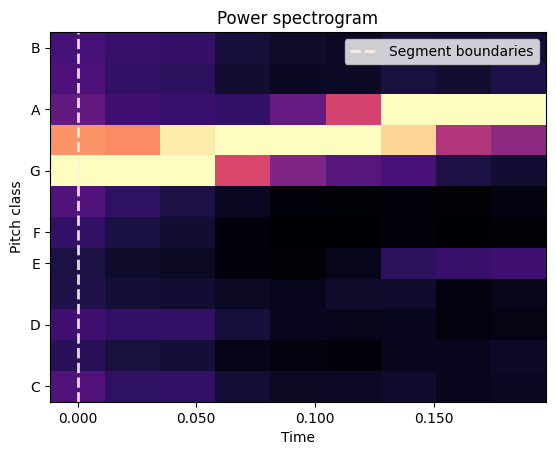

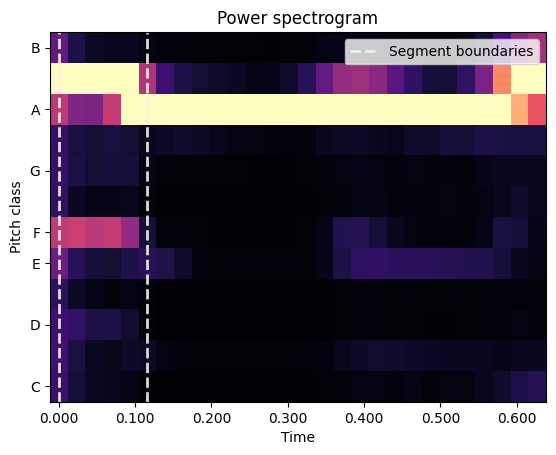

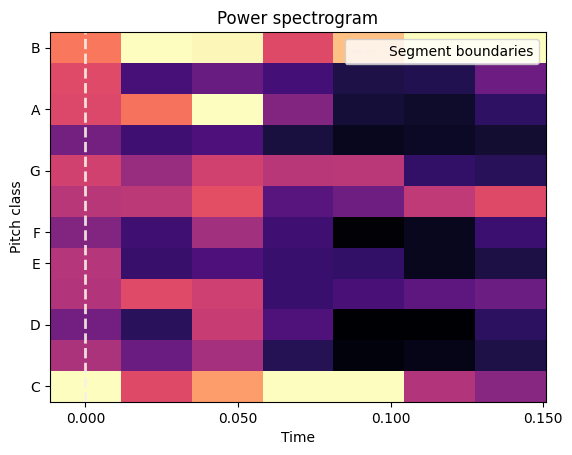

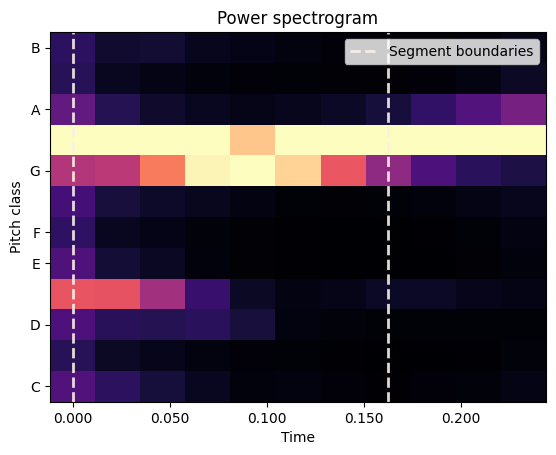

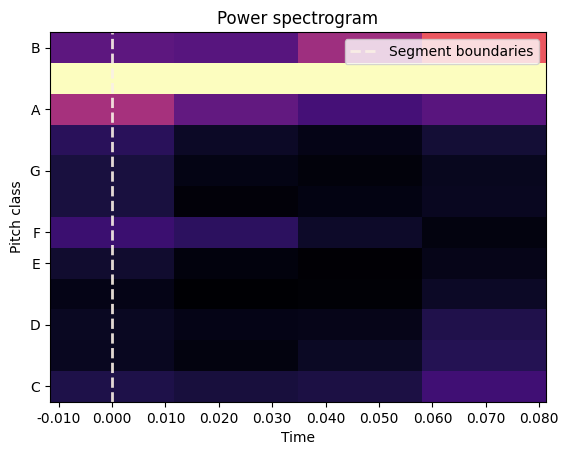

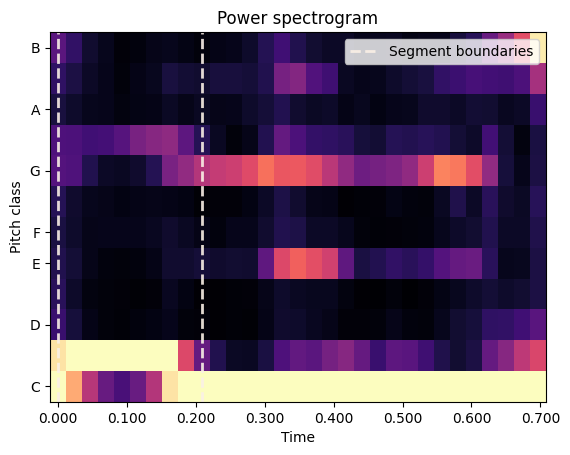

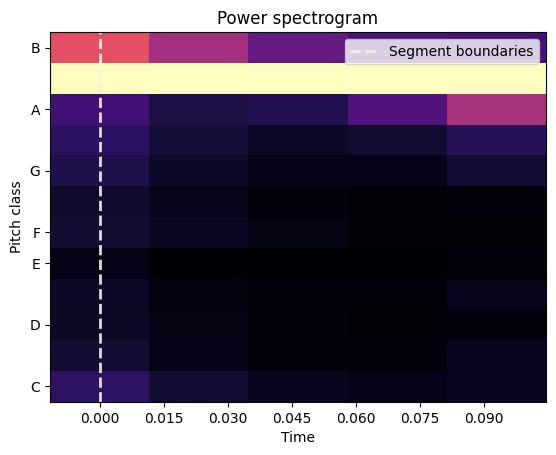

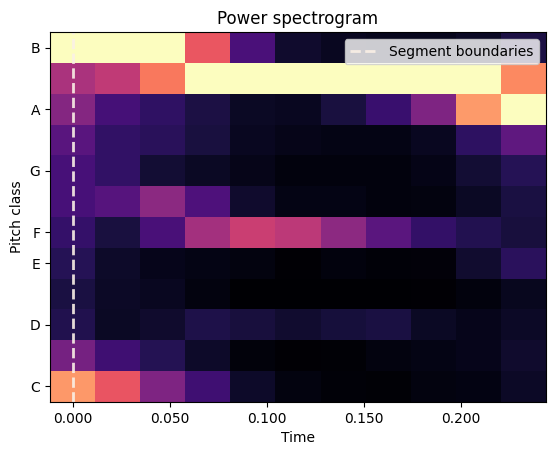

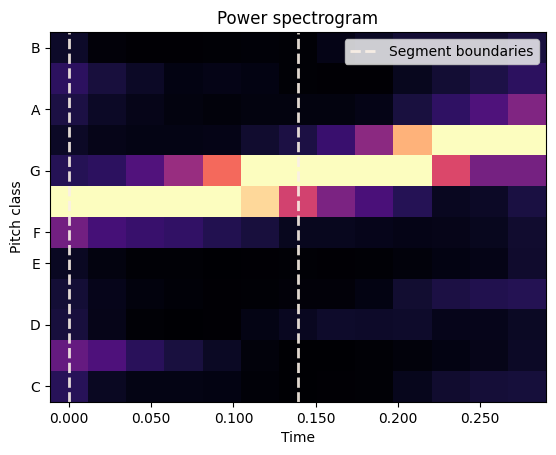

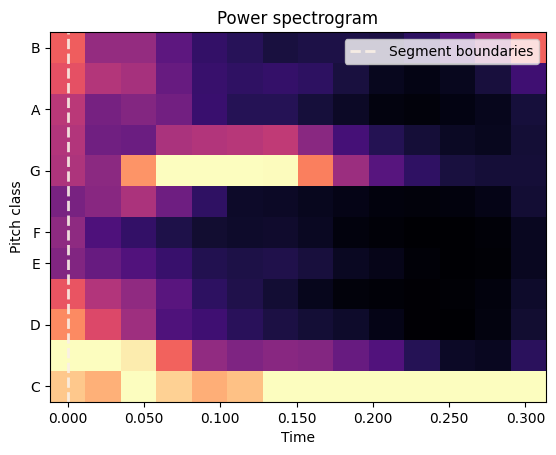

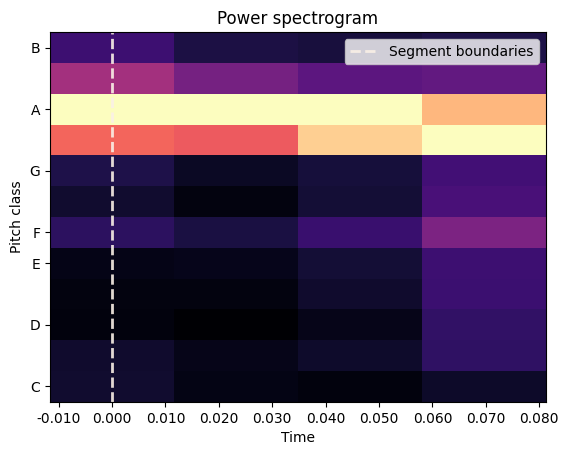

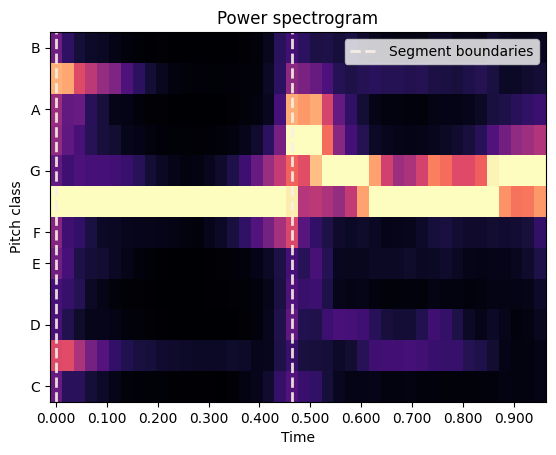

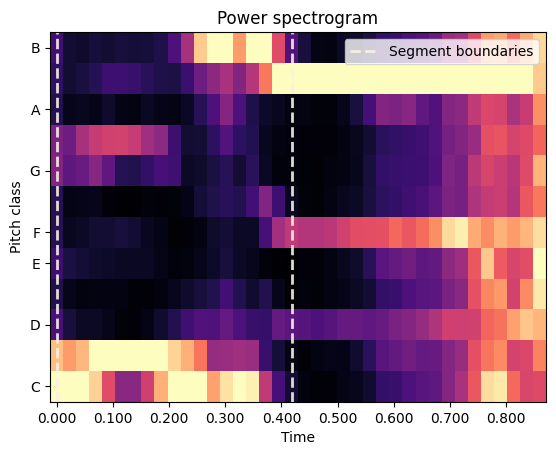

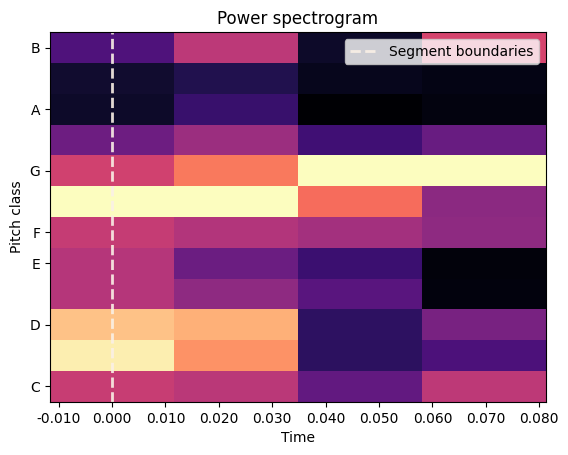

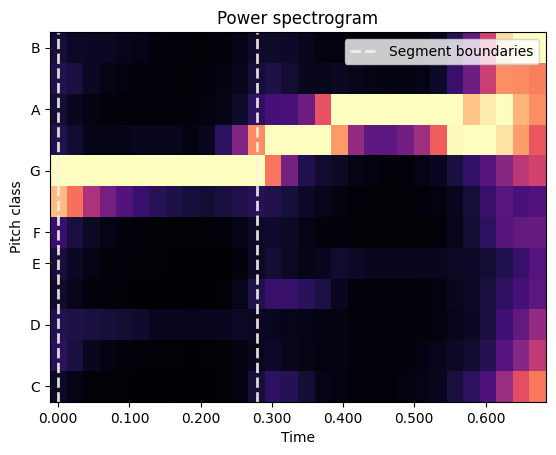

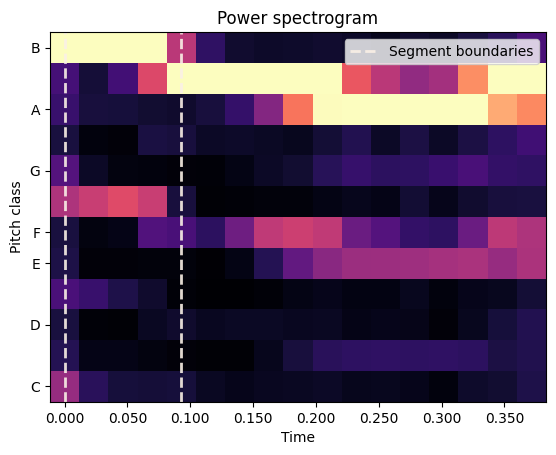

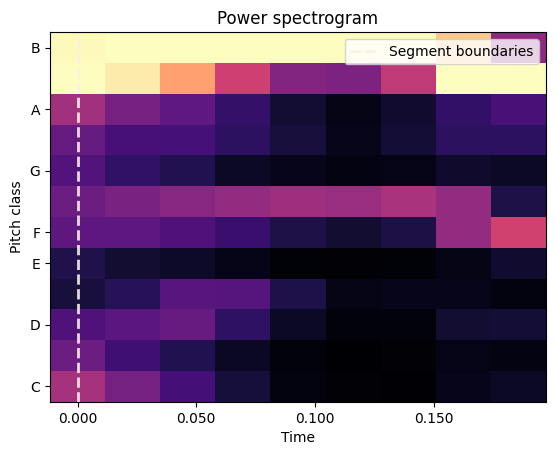

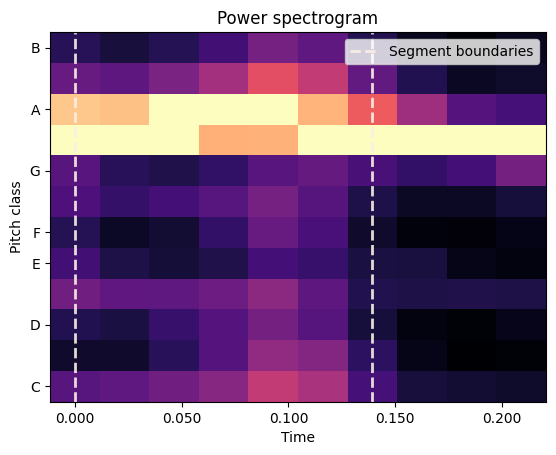

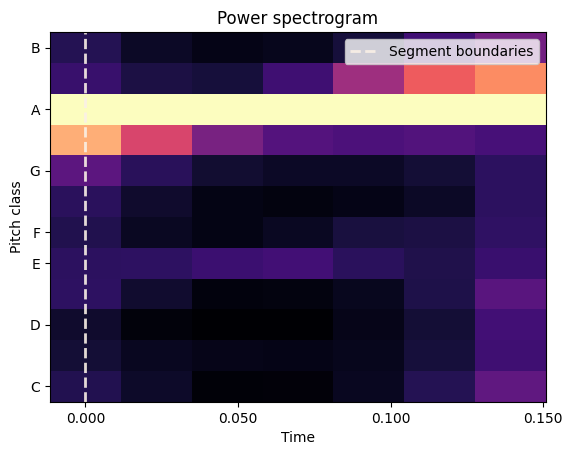

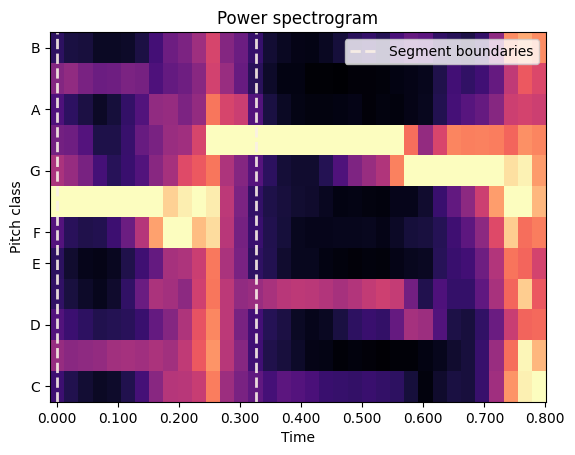

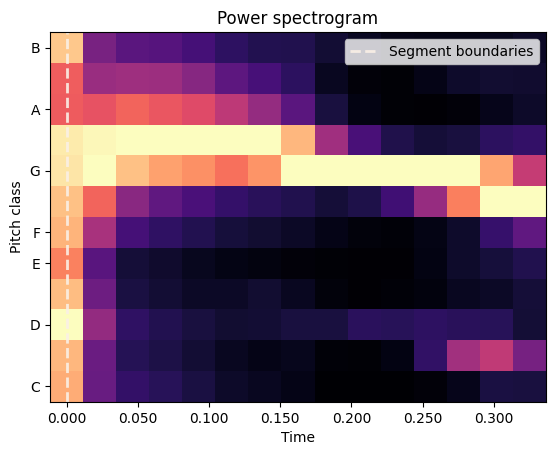

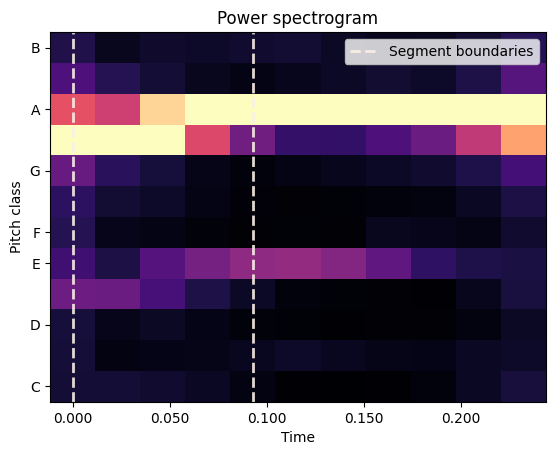

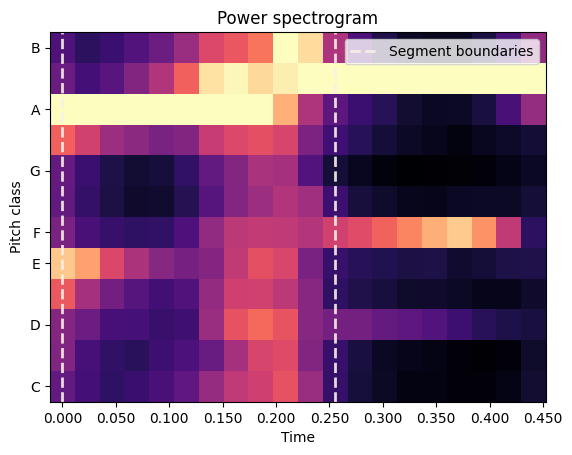

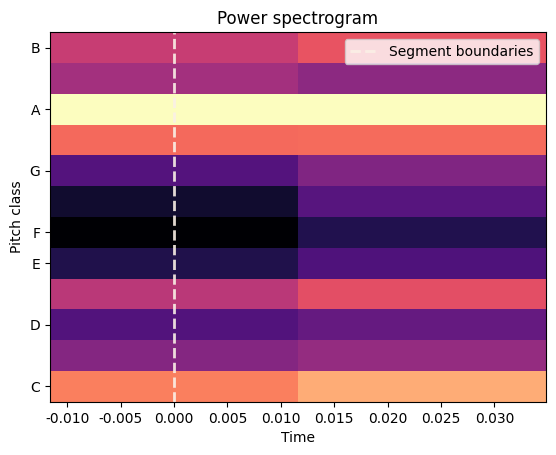

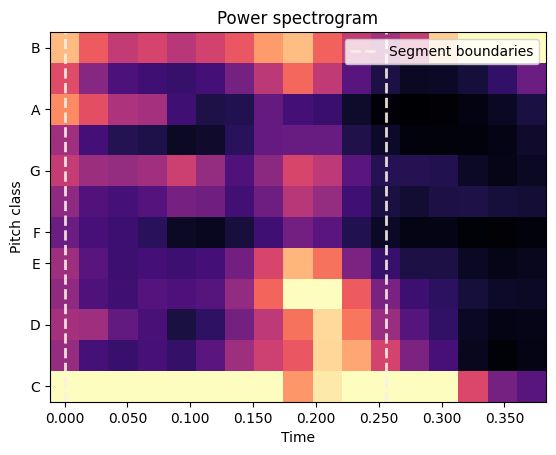

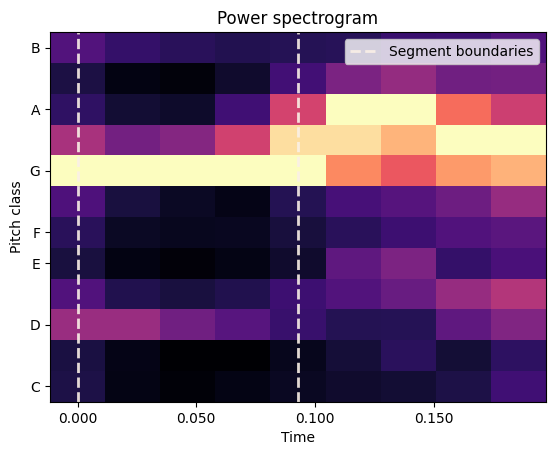

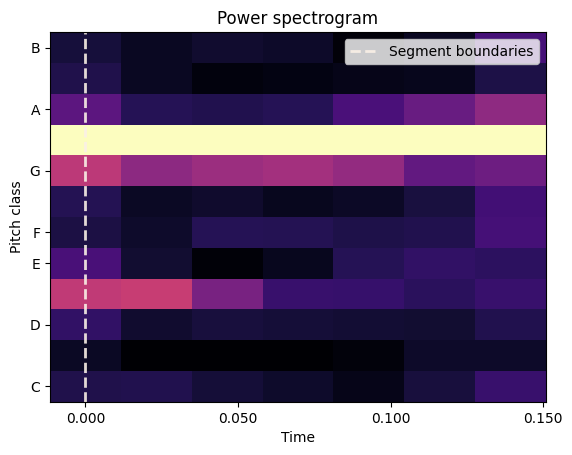

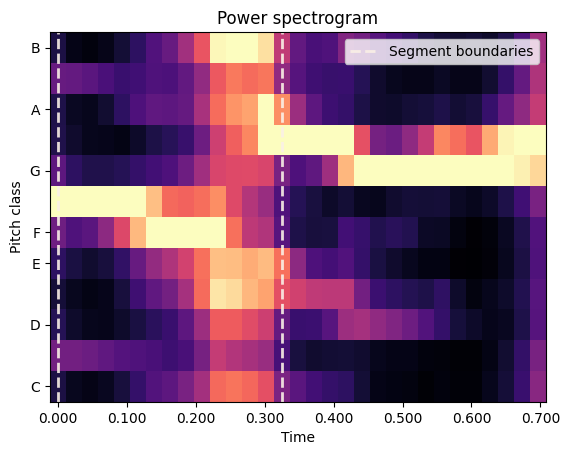

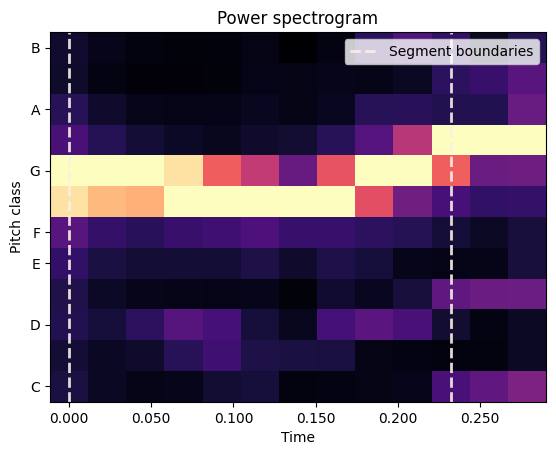

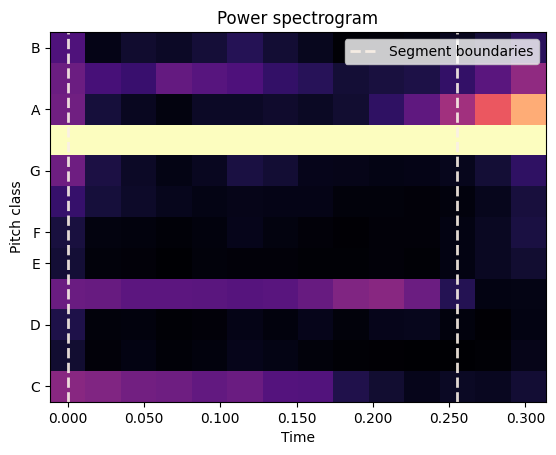

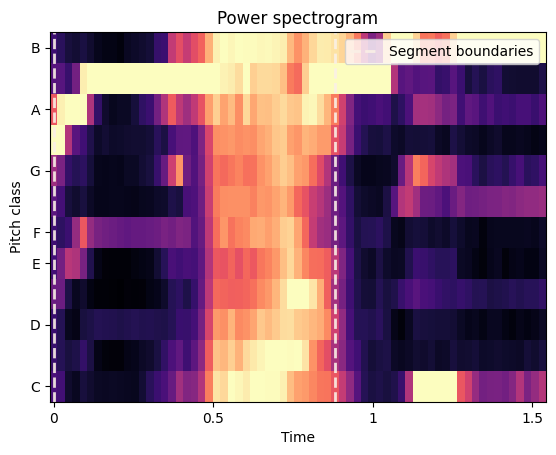

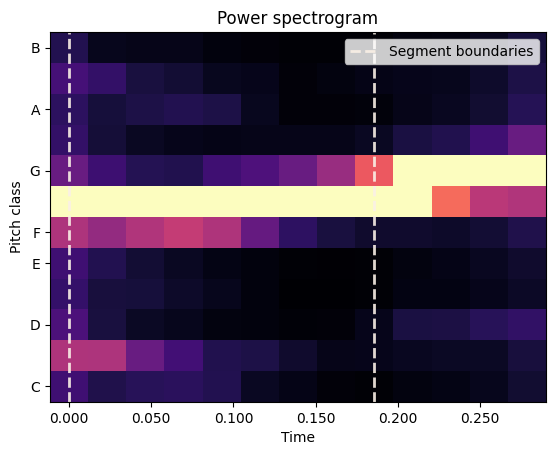

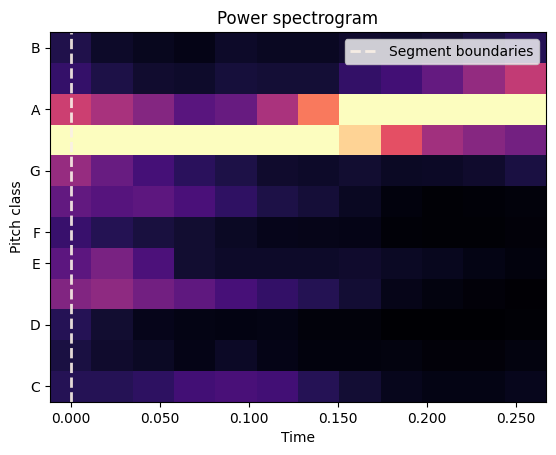

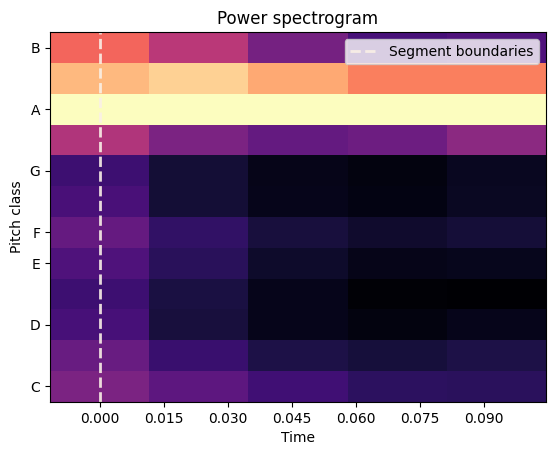

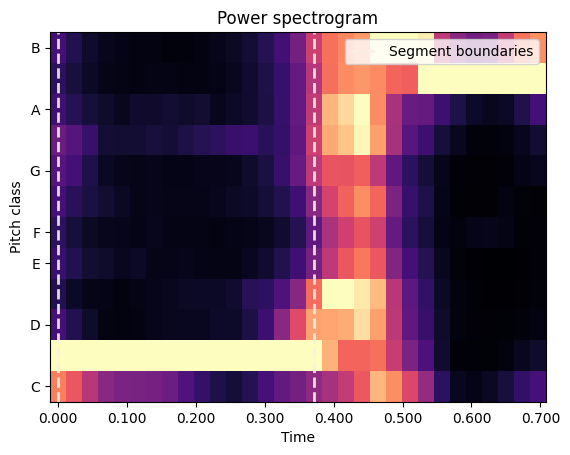

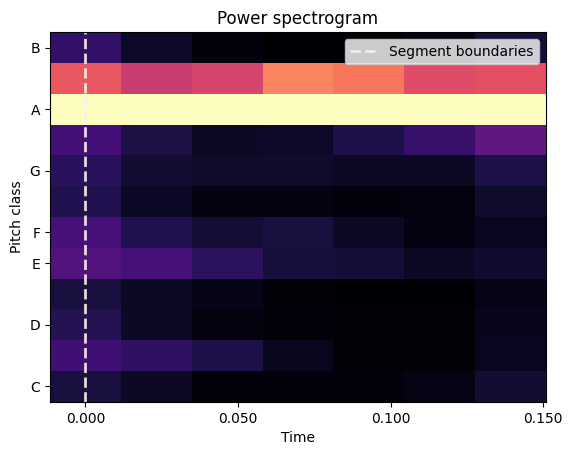

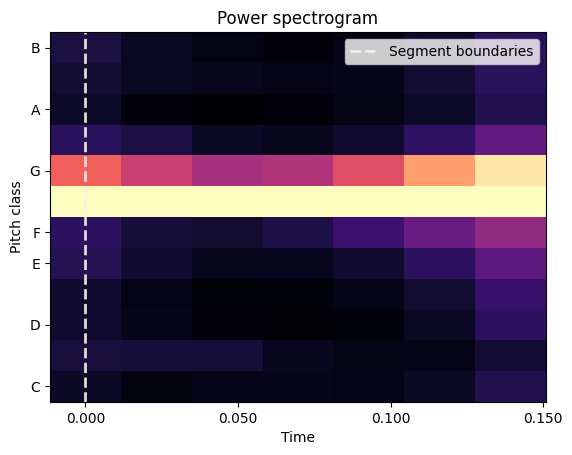

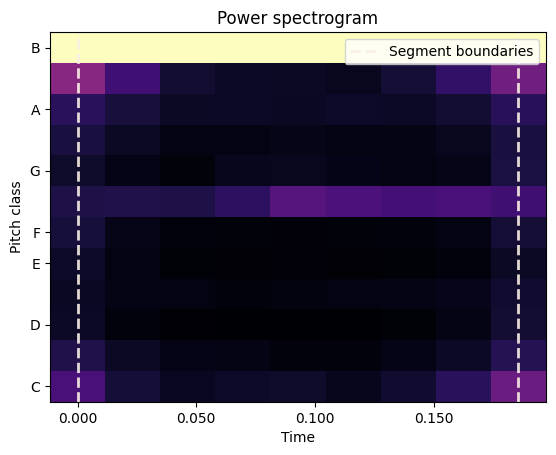

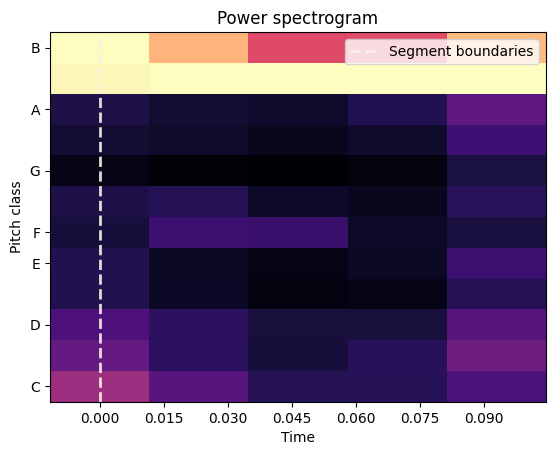

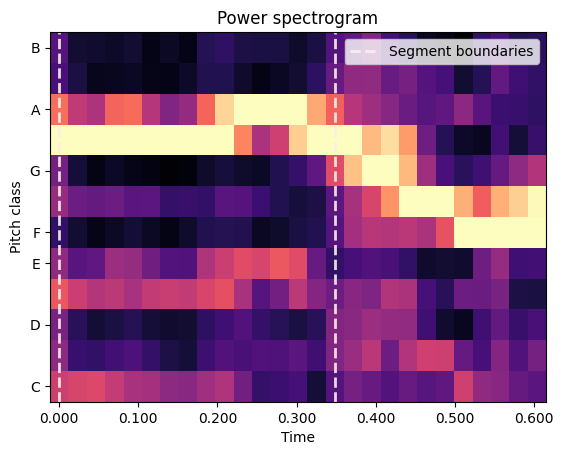

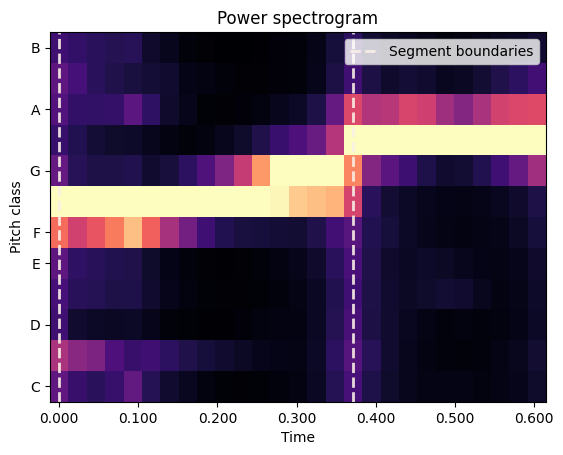

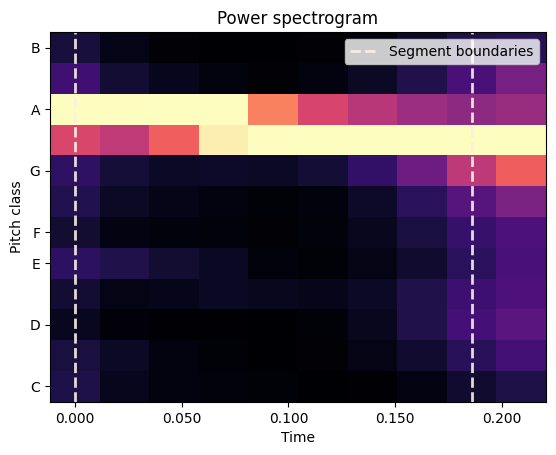

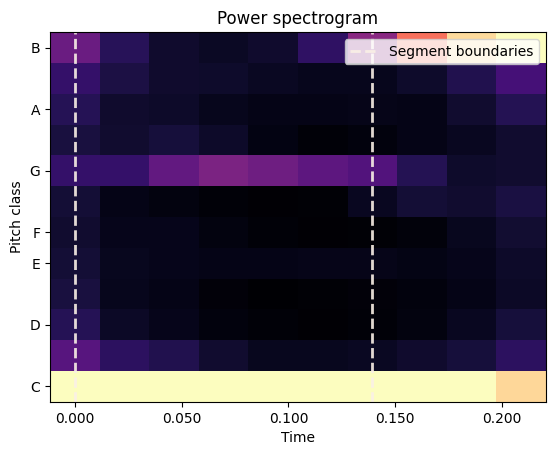

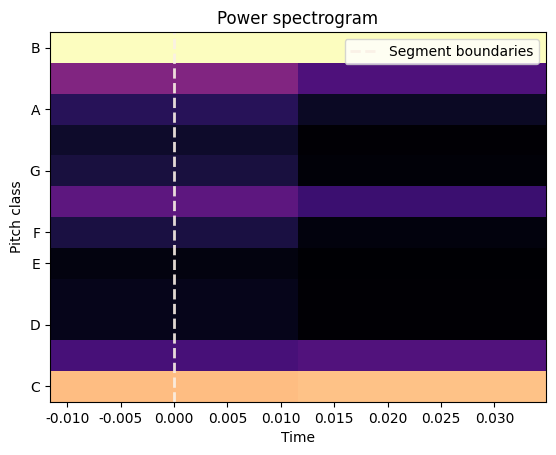

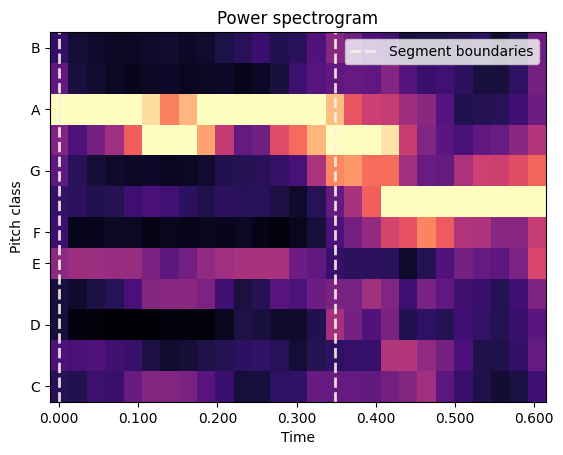

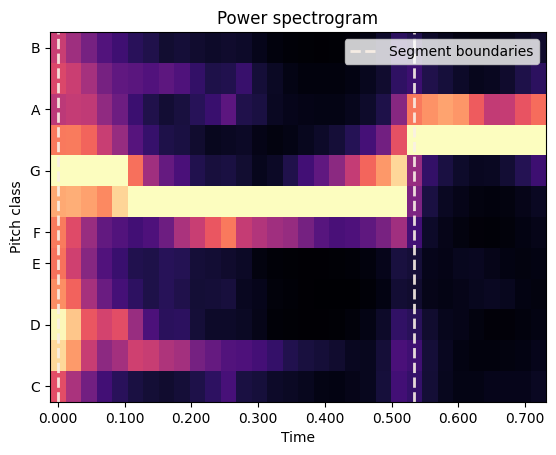

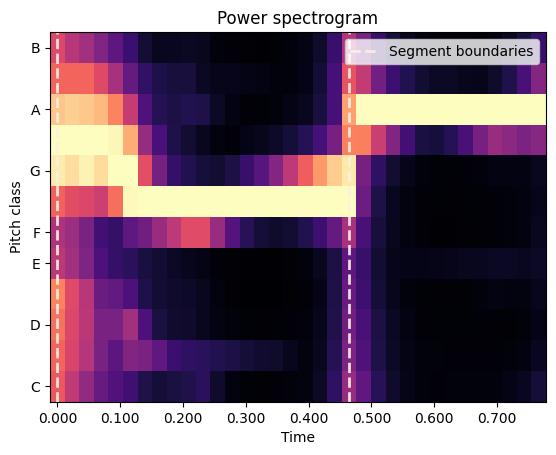

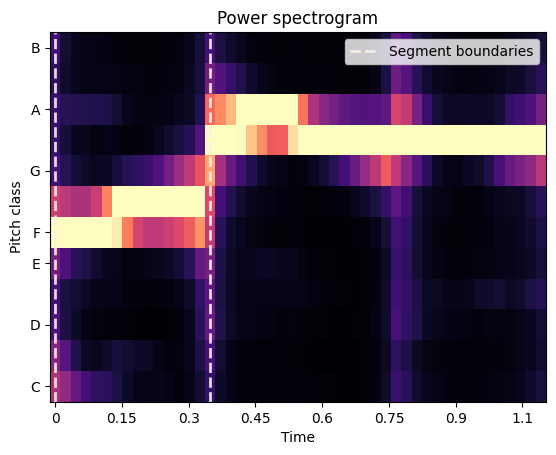

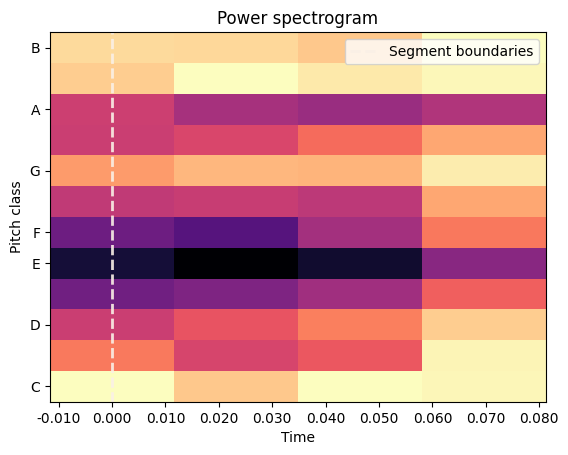

In [33]:
for i in range(len(wordseg_dict["eigen_list"])):
    item = wordseg_dict["eigen_list"][i]
    fs_dict = getWordFreqSeq(word_dict=item, Freq_list=Freq_list, times_list=times_list)
    eigen_dict = fs_dict["eigen"]
    chroma = librosa.feature.chroma_cqt(y=eigen_dict["seg_seq"], sr=sr)
    bounds = librosa.segment.agglomerative(chroma, len(fs_dict["word"]))
    bound_times = librosa.frames_to_time(bounds, sr=sr)
    test_dict = getFreqOnset(word_dict = fs_dict, sr=sr)

    fig, ax = plt.subplots()
    trans = mpt.blended_transform_factory(
            ax.transData, ax.transAxes)
    librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax)
    ax.vlines(bound_times, 0, 1, color='linen', linestyle='--',
          linewidth=2, alpha=0.9, label='Segment boundaries',
          transform=trans)
    ax.legend()
    ax.set(title='Power spectrogram')

    output_png = f'{i}{fs_dict["word"]}.png'
    output_wav = f'{i}{fs_dict["word"]}.wav'
    plt.savefig(ROOT / "jupyter" / "44022404090109" / output_png)

    audio = AudioSegment.from_file(r"D:\my_knowledge\research_assistant\python_project\speech_recognition\audio\国歌\44022404090109-32bbcd278e593d9bdc4b4d42e5880579.mp3_seg.wav")
    segment = audio[eigen_dict["start_time"] * 1000 : eigen_dict["end_time"] * 1000]
    segment.export(ROOT / "jupyter" / "44022404090109" / output_wav, format="wav")

In [26]:
test_dict

{'word': '晶',
 'eigen': {'start_time': 36.6007,
  'end_time': 37.489270000000005,
  'seg_seq': array([0.30703294, 0.27950534, 0.2281088 , ..., 0.00572025, 0.00587879,
         0.00601837], dtype=float32),
  'times': 1.097,
  'word_start_time': 36.491,
  'word_end_time': 37.588,
  'Freq_seq': [278.66110025943624,
   277.05613042340593,
   273.87386934825736,
   270.72815965904965,
   269.16888019875813,
   266.0772119191614,
   263.0210544784999,
   261.5061646776419,
   261.5061646776419,
   260.0,
   258.50251019256234,
   258.50251019256234,
   258.50251019256234,
   257.013645291753,
   255.5333556217653,
   252.59830469993753,
   252.59830469993753,
   252.59830469993753,
   252.59830469993753,
   252.59830469993753,
   254.06159179290393,
   254.06159179290393,
   255.5333556217653,
   255.5333556217653,
   257.013645291753,
   258.50251019256234,
   260.0,
   261.5061646776419,
   263.0210544784999,
   261.5061646776419,
   260.0,
   257.013645291753,
   251.14344552045984,
   24

# 以下是单个词语的测试

In [ ]:
word_dict_qilai = wordseg_dict["eigen_list"][5]["eigen"]
word_qilai = wordseg_dict["eigen_list"][5]["word"]


In [ ]:
chroma = librosa.feature.chroma_cqt(y=word_dict_qilai["seg_seq"], sr=sr)
bounds = librosa.segment.agglomerative(chroma, len(word_qilai))
bound_times = librosa.frames_to_time(bounds, sr=sr)
for timev in bound_times:
    if (timev < word_dict_qilai["times"] * 0.1 or (timev > word_dict_qilai["times"] * 0.8)) :
        mask = bound_times != timev
        bound_times = bound_times[mask]
bound_times

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mpt
fig, ax = plt.subplots()
trans = mpt.blended_transform_factory(
            ax.transData, ax.transAxes)
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax)
ax.vlines(bound_times, 0, 1, color='linen', linestyle='--',
          linewidth=2, alpha=0.9, label='Segment boundaries',
          transform=trans)
ax.legend()
ax.set(title='Power spectrogram')

In [ ]:
word_dict_qilai["times"]